#### example 2: <br/> inverse MFCC
* MFCC are difficult to interprete 
* inverses DCT converts back to mel domain
* new algorithm: `IDCT`
* can be also used for smoothing Mel energy bands

In [37]:
#### taken from https://github.com/MTG/essentia/blob/master/src/examples/tutorial/example_inverse_mfccs.py

# load audio
import essentia
import essentia.standard as ess
import matplotlib.pyplot as plt
import numpy as np



filename = 'audio/shikayet.wav'
filename_accomp = 'audio/shikayet_polyphony_separated.wav'

fs = 44100

audio = ess.MonoLoader(filename = filename, 
                                          sampleRate = fs)()
# dynamic range expansion as done in HTK implementation
# audio = audio*2**15

audio_accomp = ess.MonoLoader(filename = filename_accomp, 
                                          sampleRate = fs)()
# dynamic range expansion as done in HTK implementation
# audio_accomp = audio_accomp*2**15


NUM_BANDS  = 26
DCT_TYPE = 3
LIFTERING = 22
NUM_MFCCs = 13
HIGH_FREQ_BOUND = 8000

hopSize = 1024 
frameSize = fftSize = 2048
spectrumSize= fftSize//2+1

w = ess.Windowing(type = 'hamming', #  corresponds to htk default  USEHAMMING = T
                        size = fftSize, 
                        normalized = False,
                        zeroPhase = False)
spectrum = ess.Spectrum(size = fftSize)


In [23]:
### initialize mfccs and inverse dct
mfcc_htk = ess.MFCC(inputSize = spectrumSize,
                        type = 'magnitude', # htk uses mel filterbank magniude
                        warpingFormula = 'htkMel', # htk's mel warping formula
                        weighting = 'linear', # computation of filter weights done in Hz domain
                        highFrequencyBound = 8000, # corresponds to htk default
                        lowFrequencyBound = 0, # corresponds to htk default
                        numberBands = NUM_BANDS, # corresponds to htk default  NUMCHANS = 26
                        numberCoefficients = 13,
                        normalize = 'unit_max', # htk filter normaliation to have constant height = 1  
                        dctType = 3, # htk uses DCT type III
                        logType = 'log',
                        liftering = LIFTERING) # corresponds to htk default CEPLIFTER = 22

idct = ess.IDCT(inputSize=NUM_MFCCs, 
                outputSize=NUM_BANDS, 
                dctType = 3, 
                liftering = LIFTERING)

In [51]:
### compute inverse dct of mfccs for audio 1
mel_bands_htk = []
all_melbands_smoothed = []
for frame in ess.FrameGenerator(audio, frameSize = frameSize, hopSize = hopSize):
        melbands, mfcc_coeffs = mfcc_htk(spectrum(w(frame)))
        melbands_smoothed = np.exp(idct(mfcc_coeffs[:])) # inverse the log taken in MFCC computation
        mel_bands_htk.append(melbands)
        all_melbands_smoothed.append(melbands_smoothed)


In [52]:

### compute inverse dct of mfccs for audio 2
mel_bands_htk_accomp = []
all_melbands_smoothed_accomp = []
for frame in ess.FrameGenerator(audio_accomp, frameSize = frameSize, hopSize = hopSize):
    spect = spectrum(w(frame))
    melbands_accomp, mfcc_coeffs = mfcc_htk(spect)
    melbands_smoothed = np.exp(idct(mfcc_coeffs[:])) # inverse the log taken in MFCC computation
        
    mel_bands_htk_accomp.append(melbands_accomp)
    all_melbands_smoothed_accomp.append(melbands_smoothed)

In [42]:
# visualize mel bands

def visualize_mel_bands(mel_bands, title, which_figure):
    mel_bands = essentia.array(mel_bands).T
    plt.subplot(3, 1, which_figure)
    librosa.display.specshow(mel_bands, sr=44100, hop_length=hopSize, x_axis='time', y_axis='mel', fmax=HIGH_FREQ_BOUND)
    plt.colorbar(); plt.title(title)

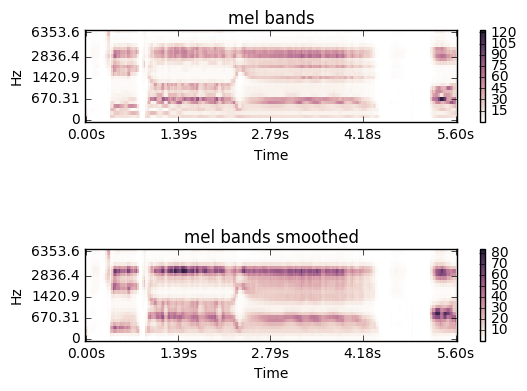

In [53]:
#### plot mel bands 
import librosa 
visualize_mel_bands(mel_bands_htk, 'mel bands', 1)
visualize_mel_bands(all_melbands_smoothed, 'mel bands smoothed', 3)
plt.show() 


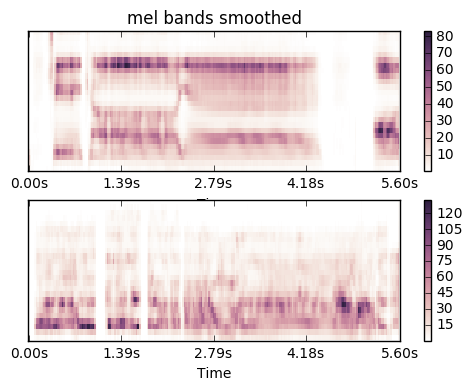

In [32]:
#### plot  inverted smoothed mel bands. example with another audio with accompaniment
import librosa 
mel_bands = essentia.array(all_melbands_smoothed).T
plt.subplot(2, 1, 1)
librosa.display.specshow(mel_bands, sr=44100, hop_length=hopSize, x_axis='time')
plt.colorbar(); plt.title('mel bands smoothed')

mel_bands = essentia.array(all_melbands_smoothed_accomp).T
plt.subplot(2, 1, 2)
librosa.display.specshow(mel_bands, sr=44100, hop_length=hopSize, x_axis='time')
plt.colorbar(); # plt.title('mel bands with accompaniment')
plt.show() 

In what applications is new timbre parameters useful ?